In [2]:
import pandas as pd
dir_path = os.getcwd()


In [14]:
d_types = ['data', 'test']
data = dict()
for d_type in d_types:
        path = dir_path +"/"+"classification_data_HWK2/EMGaussian." + d_type 
        data[d_type] = pd.read_csv(path, sep=' ', header=None).values

In [15]:
print(data['data'][0:5, :])

[[ 0.91029   0.016192]
 [-2.531     6.6981  ]
 [ 4.3602    8.3541  ]
 [-0.70489  -0.51343 ]
 [-5.7383   -6.2088  ]]


In [153]:
def computeKMeans(niterMax):
    X = data['data']
    x0min = np.min(X[:, 0])
    x0max = np.max(X[:, 0])
    x1min = np.min(X[:, 1])
    x1max = np.max(X[:, 1])
    oldCenters = [[0,0] for i in range(4)]
    centers = np.random.rand(4,2)
    centers[:,0] = ((x0max - x0min)*centers[:,0])+x0min
    centers[:,1] = ((x1max - x1min)*centers[:,1])+x1min
    clusters = [4 for i in range(len(X))]
    i = 0
    while not np.array_equal(centers,oldCenters) and i < niterMax:
        oldCenters = np.copy(centers)
        i += 1
        for j in range(len(X)):
            minDist = 1000000000
            cluster = 4
            for k in range(len(centers)):
                dist = np.linalg.norm(X[j]-centers[k])
                if dist < minDist:
                    minDist = dist
                    cluster = k
            clusters[j]=cluster
        
        for l in range(len(centers)):
            equal = [l for i in range(len(X))]
            subset = [clusters[m]==l for m in range(len(clusters))]
            Xsubset = X[subset,:]
            if len(Xsubset) > 0:
                centers[l] = np.mean(Xsubset)
                
            
    return centers, clusters
            
        

In [167]:
def plotKMeans(X, centers, clusters):
    for l in range(len(centers)):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        Xsubset = X[subset,:]
        x0 = Xsubset[:, 0]
        x1 = Xsubset[:, 1]
        plt.scatter(x0, x1)
        
    plt.scatter(centers[:,0], centers[:,1])
    
    plt.title("K-means")
    plt.show()
    
    
def computeDistortionMeasures(X, centers, clusters):
    measure = 0
    for l in range(len(centers)):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        Xsubset = X[subset,:]
        norm = [np.linalg.norm(Xsubset[m]-centers[l]) for m in range(len(Xsubset))]
        measure += sum(norm)
        
    return measure
        
    

In [168]:
X = data['data']
centers, clusters = computeKMeans(1000)
computeDistortionMeasures(X, centers, clusters)

1663.1666155071175

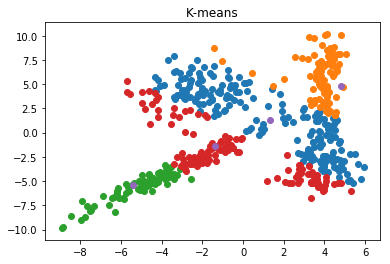

centers : 
 
[ 1.3114364950248756 1.3114364950248756 ]
[ 4.8238452173913045 4.8238452173913045 ]
[ -5.3922895833333335 -5.3922895833333335 ]
[ -1.3675226777777778 -1.3675226777777778 ]
distortion measure :  1660.0493530993785


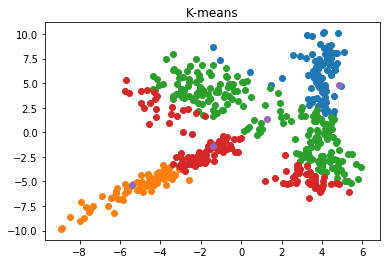

centers : 
 
[ 4.8238452173913045 4.8238452173913045 ]
[ -5.3922895833333335 -5.3922895833333335 ]
[ 1.3047858193069306 1.3047858193069306 ]
[ -1.3774892649253734 -1.3774892649253734 ]
distortion measure :  1659.8426785040442


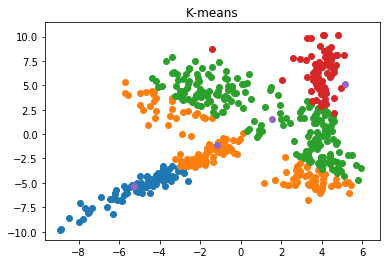

centers : 
 
[ -5.28247894736842 -5.28247894736842 ]
[ -1.1589553503401362 -1.1589553503401362 ]
[ 1.5542976025000002 1.5542976025000002 ]
[ 5.13645974025974 5.13645974025974 ]
distortion measure :  1666.9638195211205


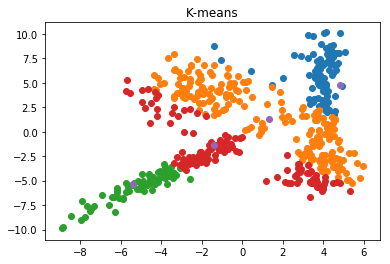

centers : 
 
[ 4.8238452173913045 4.8238452173913045 ]
[ 1.3047858193069306 1.3047858193069306 ]
[ -5.3922895833333335 -5.3922895833333335 ]
[ -1.3774892649253734 -1.3774892649253734 ]
distortion measure :  1659.8426785040442


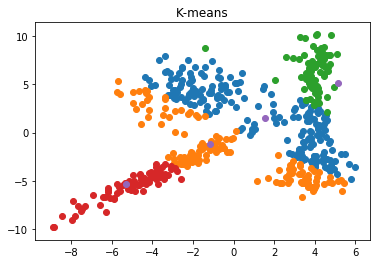

centers : 
 
[ 1.5542976025000002 1.5542976025000002 ]
[ -1.1589553503401362 -1.1589553503401362 ]
[ 5.13645974025974 5.13645974025974 ]
[ -5.28247894736842 -5.28247894736842 ]
distortion measure :  1666.9638195211205


In [174]:
for i in range(5):
    X = data['data']
    centers, clusters = computeKMeans(1000)
    plotKMeans(X, centers, clusters)
    distortionMeasure = computeDistortionMeasures(X, centers, clusters)
    print("centers : \n ")
    for i in range(len(centers)):
        print("[",*centers[i],"]")
    print("distortion measure : ",distortionMeasure)